In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import yfinance as yf 
from datetime import datetime, timedelta

from sklearn.covariance import LedoitWolf

In [2]:
np.random.seed()

# 1. Markowitz et frontière efficiente en théorie

In [7]:
# extraction des données

class FinancialData():

    def __init__(self, tickers_csv_path, num_tickers):
        self.tickers_csv_path = tickers_csv_path
        if isinstance(num_tickers, int):
            num_tickers = list(range(num_tickers)) 
        self.num_tickers = num_tickers
        self.tickers = None
        self.data_clean = None
        self.mu = None
        self.Sigma = None

    def extract_tickers(self):
        tickers_df = pd.read_csv(self.tickers_csv_path)
        list_tickers = tickers_df.loc[self.num_tickers, 'Ticker'].tolist()
        self.tickers = list_tickers
    
    def get_returns(self, start, end, period="1d"):
        data = yf.download(self.tickers, start=start, end=end, period=period)['Adj Close']
        data = data.pct_change(fill_method=None).dropna()
        data.index = data.index.strftime("%Y-%m-%d")
        self.data_clean = data

    def calculate_statistics(self):
        if self.data_clean is not None:
            self.mu = self.data_clean.mean(axis=0).values
            self.Sigma = self.data_clean.cov().to_numpy()
        else:
            print("get returns before please")


In [8]:
# envisager de coder un truc qui gere des lambdas de plusieurs tailles 

def get_markowitz_weights(lam, mu, Sigma):
    Sigma_inv = np.linalg.inv(Sigma)
    n = len(mu)
    e = np.ones(n)

    eT_Sigma_inv_e = e.T @ Sigma_inv @ e
    eT_Sigma_inv_mu = e.T @ Sigma_inv @ mu

    term1 = Sigma_inv @ e / eT_Sigma_inv_e
    
    adjusted_mu = Sigma_inv @ mu - (eT_Sigma_inv_mu / eT_Sigma_inv_e) * (Sigma_inv @ e)
    term2 = (1 / lam) * adjusted_mu
    w_star = term1 + term2
    return w_star

def portfolio_performance(weights, mean_returns, cov_matrix):
    rendement_portefeuille = np.dot(weights, mean_returns)
    variance_portefeuille = np.dot(weights.T, np.dot(cov_matrix, weights))
    risque_portefeuille = np.sqrt(variance_portefeuille)
    return rendement_portefeuille, risque_portefeuille



In [41]:
# input 

tickers_csv_path = "C:\\Users\\Nicola\\clones_github\\DL-Portfolio-CMAP\\data\\S&P 500 tickers.csv"
num_tickers = 20 # doit etre au minimum 2 
end = datetime.today()
start = end - timedelta(days=365.25*20)

In [42]:
# output

data_extractor_5 = FinancialData(tickers_csv_path, num_tickers)
data_extractor_5.extract_tickers()
data_extractor_5.get_returns(start=start, end=end)
data_extractor_5.calculate_statistics()
rets_df = data_extractor_5.data_clean
mu_5 = data_extractor_5.mu
Sigma_5 = data_extractor_5.Sigma

rets_df.head()

[*********************100%***********************]  20 of 20 completed


Ticker,A,ABBV,ABNB,ABT,ACN,ADBE,AES,AFL,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMD,AOS,APD,ARE,LNT,MMM
Date,,,,,,,,,,,,,,,,,,,,
2020-12-11,-0.002778,-0.010699,-0.037731,0.004694,-0.001341,-0.002013,0.014388,-0.011246,0.001160,-0.019656,-0.002577,-0.027491,-0.009391,-0.009670,-0.000109,0.000888,-0.005431,0.009181,-0.002893,0.003055
2020-12-14,-0.014686,-0.020124,-0.066427,-0.002149,-0.008461,0.022084,0.007092,-0.014273,-0.002511,-0.029427,-0.005463,-0.019046,0.004213,0.001004,0.034152,-0.016856,-0.007331,0.001449,-0.007155,-0.005402
2020-12-15,0.005568,-0.013244,-0.040000,0.006180,0.013538,-0.007771,0.046009,0.015158,0.005810,0.025043,0.023775,0.028612,0.010012,0.021304,0.024689,0.018228,0.017370,0.019383,0.020257,0.009245
2020-12-16,-0.001278,0.017701,0.105689,-0.001024,0.001619,0.015042,-0.017056,-0.004234,0.006258,-0.015659,0.000078,-0.011524,0.004720,-0.004476,-0.002780,-0.023750,-0.004111,0.008230,-0.014128,0.004179
2020-12-17,0.014756,0.002389,0.065657,0.013415,0.068781,0.011145,0.008676,0.002910,0.010429,0.012520,0.020103,0.008442,0.001316,0.014568,-0.000103,0.003268,-0.001115,0.000394,0.001743,0.007069


In [43]:
# Fonction de LA 

def efficient_frontier(returns, covariance, num_points=51):
    ones = np.ones(shape=len(returns))
    cov_inv = np.linalg.inv(covariance)
    weights_minvar = (cov_inv @ ones   ) / (ones @ cov_inv @ ones   )
    weights_market = (cov_inv @ returns) / (ones @ cov_inv @ returns)
    weights_maxret = (returns == returns.max())

    alpha_max = (  (returns @ (weights_maxret - weights_minvar))
                 / (returns @ (weights_market - weights_minvar)))
    alpha = np.linspace(start=0, stop=alpha_max, num=num_points)

    efficient_frontier = (
            alpha[:, np.newaxis] * weights_market[np.newaxis, :]
            + (1 - alpha)[:, np.newaxis] * weights_minvar[np.newaxis, :]
    )
    return pd.DataFrame(efficient_frontier, columns=returns.index, index=alpha)

In [66]:
weights = efficient_frontier(pd.Series(mu_5), Sigma_5).to_numpy() # fonction de LA 

Text(0, 0.5, 'mean')

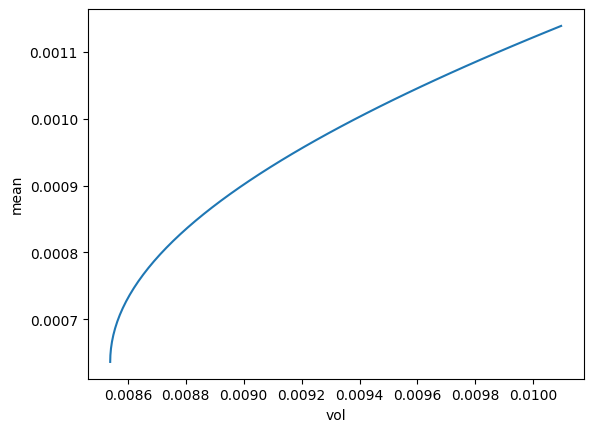

In [67]:
# calcul de la moyenne et de l'écart type des rendements des portefeuilles efficients pour difféérents coefficients d'aversion au risque 

n_lambdas = 1000
lambdas = np.logspace(0,2, n_lambdas)
# weights = np.array(list(map(lambda lam: get_markowitz_weights(lam, mu_5, Sigma_5), lambdas))) # ma fonction




mu_port = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[0], weights)))
sigma_port = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[1], weights)))


plt.plot(sigma_port, mu_port)

plt.xlabel("vol")
plt.ylabel("mean")

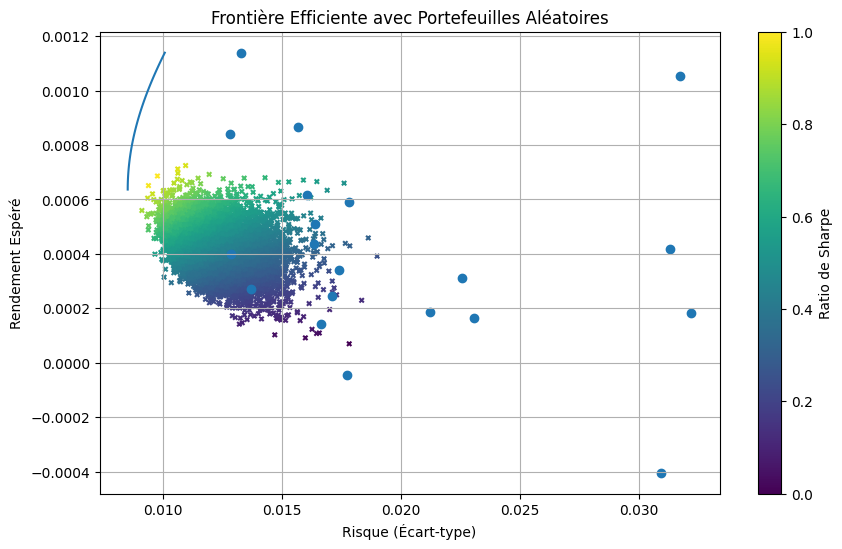

In [68]:
# tirer des portefeuilles aléatoires 

n_samples=10**4
random_weights = np.random.dirichlet(np.ones(num_tickers), size=n_samples)

mu_random = random_weights @ mu_5
sigma_squared_random = random_weights @ Sigma_5 @ random_weights.T #simplifier ? 
sigma_random = np.sqrt(np.diag(sigma_squared_random))
sharpe_random = mu_random / sigma_random

plt.figure(figsize=(10, 6))
plt.scatter(sigma_random, mu_random, c=sharpe_random, cmap='viridis', marker='x', s=10)
plt.scatter(np.sqrt(np.diag(Sigma_5)) ,mu_5)
plt.plot(sigma_port, mu_port)
plt.title('Frontière Efficiente avec Portefeuilles Aléatoires')
plt.xlabel('Risque (Écart-type)')
plt.ylabel('Rendement Espéré')
plt.colorbar(label='Ratio de Sharpe')
plt.grid()
plt.show()


# 2. Markowitz et frontière efficiente en pratique 

#### Checker pourquoi ça marche pas  (différences pas trop visibles)

In [64]:
n_samples = 250
dim = 5 

Y = np.random.multivariate_normal(mean=mu_5, cov=Sigma_5, size=250)

cov_hat_Y = np.cov(Y, rowvar=False) 
cov_hat_Y

cov_LW = LedoitWolf()
cov_LW.fit(Y)
cov_LW = cov_LW.covariance_

In [59]:
np.linalg.norm(cov_hat_Y - Sigma_5)

0.0006052928571109732

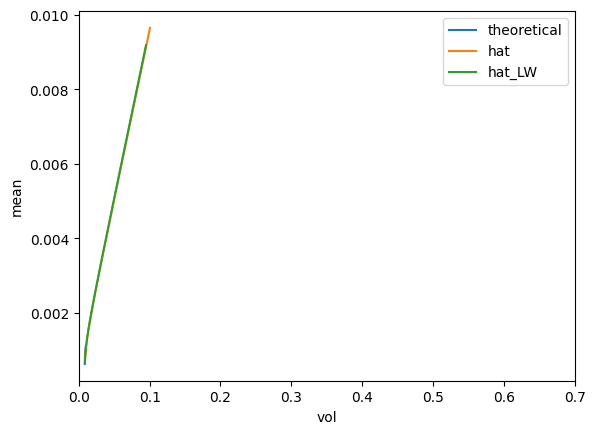

In [70]:
weights_hat = np.array(list(map(lambda lam: get_markowitz_weights(lam, mu_5, cov_hat_Y), lambdas)))
weights_hat_LW = np.array(list(map(lambda lam: get_markowitz_weights(lam, mu_5, cov_LW), lambdas)))

mu_port_hat = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[0], weights_hat)))
sigma_random_hat = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[1], weights_hat)))

mu_port_hat_true = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[0], weights_hat_LW)))
sigma_random_hat_true = np.array(list(map(lambda weight: portfolio_performance(weights=weight, mean_returns=mu_5, cov_matrix=Sigma_5)[1], weights_hat_LW)))


plt.plot(sigma_port, mu_port, label='theoretical')
plt.plot(sigma_random_hat, mu_port_hat, label='hat')
plt.plot(sigma_random_hat_true, mu_port_hat_true , label='hat_LW')

plt.xlabel("vol")
plt.ylabel("mean")
plt.legend()